# Guide to the `Place` API

## Using `contextily` to get maps & more of named places

Contextily allows to get location information as well as a map from named places through the `Places` API. These places could be countries, cities, or streets. The geocoding is handled by [geopy](https://geopy.readthedocs.io/en/stable/) and the default service provider is OpenStreetMap's Nominatim. We can get a place by instantiating a ```Place``` object by simply passing a query string that is passed on to the geocoder.

In [1]:
import geopandas as gpd
from shapely.geometry import box, Point
from contextily import Place
import contextily as cx
import numpy as np
from matplotlib import pyplot as plt
import rasterio
from rasterio.plot import show as rioshow

plt.rcParams["figure.dpi"] = 70 # lower image size

### Instantiating a `Place` object

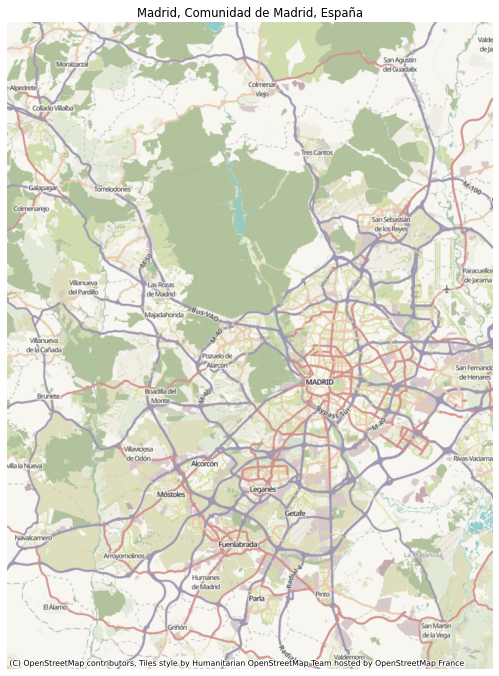

In [2]:
madrid = Place("Madrid")
ax = madrid.plot()

The zoom level is detected automatically, but can be adjusted through the `zoom` argument.

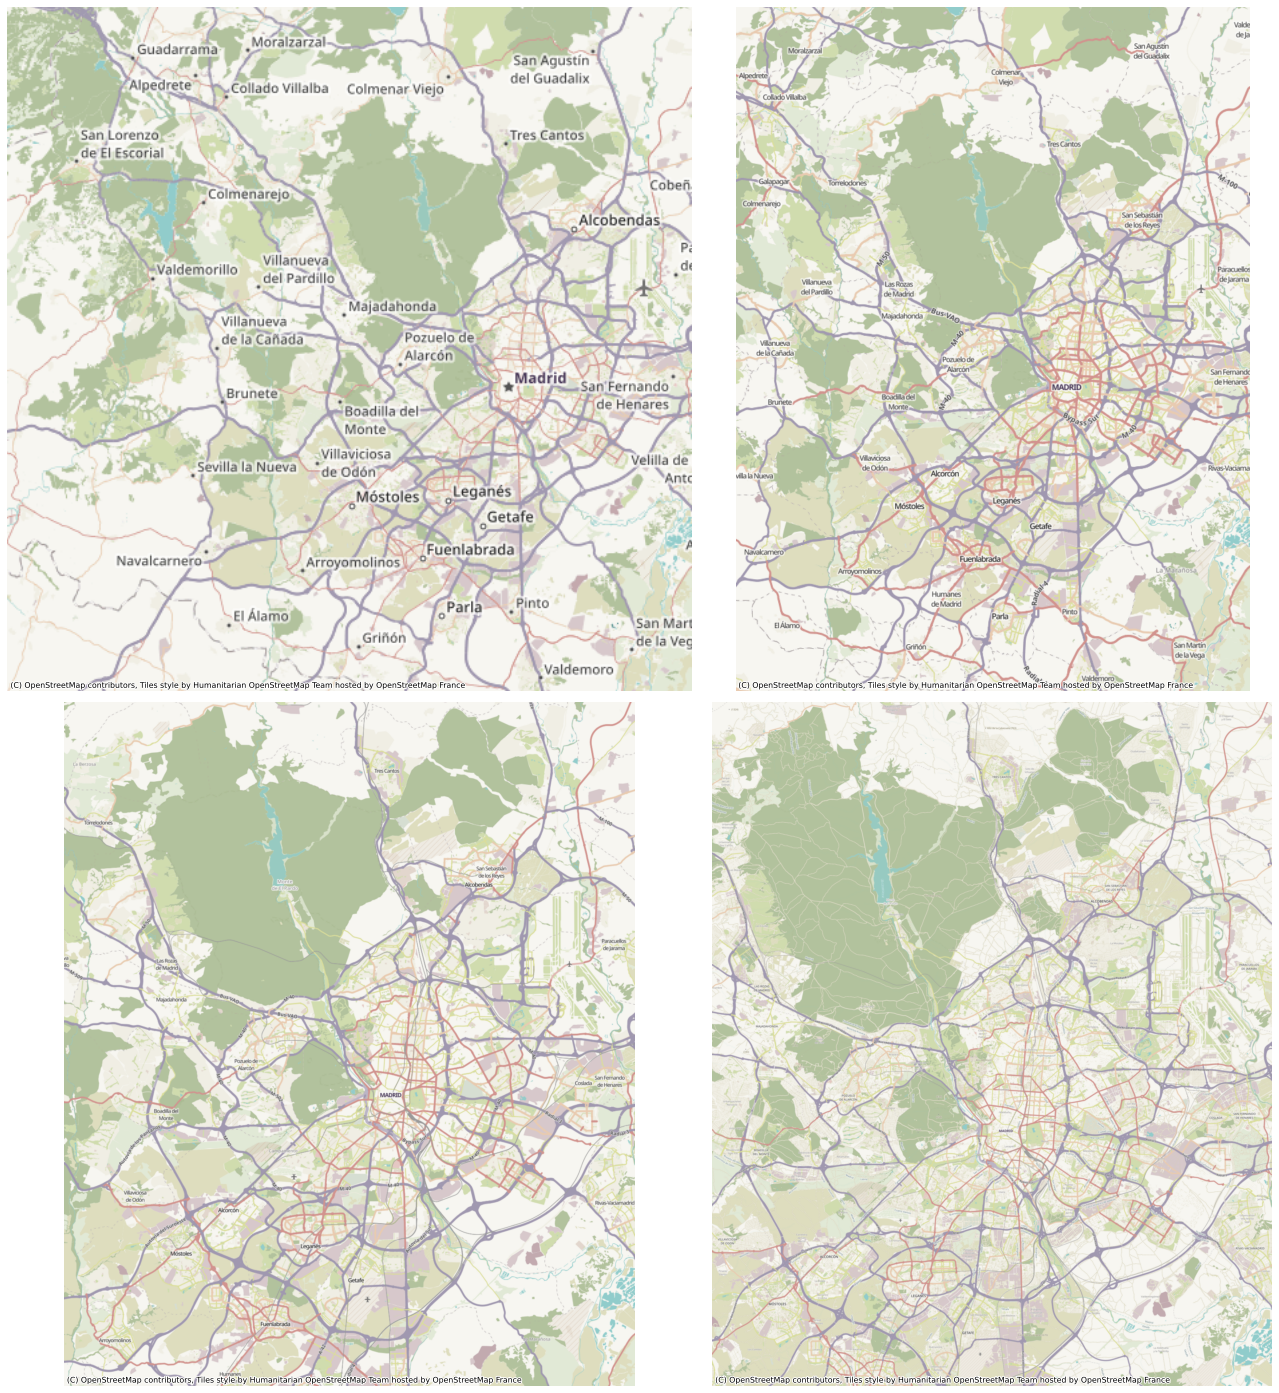

In [3]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
for i, zoom_lvl in enumerate([10, 11, 12, 13]):
    ax = Place("Madrid", zoom=zoom_lvl).plot(ax=axs.flatten()[i])
    ax.axis("off")
    plt.tight_layout()

Bear in mind that increasing the zoom level by one leads to four times as many tiles being downloaded:

In [4]:
for zoom_lvl in [12, 13, 14, 15, 16]:
    cx.howmany(*madrid.bbox, zoom_lvl, ll=True)

Using zoom level 12, this will download 30 tiles
Using zoom level 13, this will download 99 tiles
Using zoom level 14, this will download 357 tiles
Using zoom level 15, this will download 1394 tiles
Using zoom level 16, this will download 5508 tiles


The basemap provider can be set with the `source` argument.

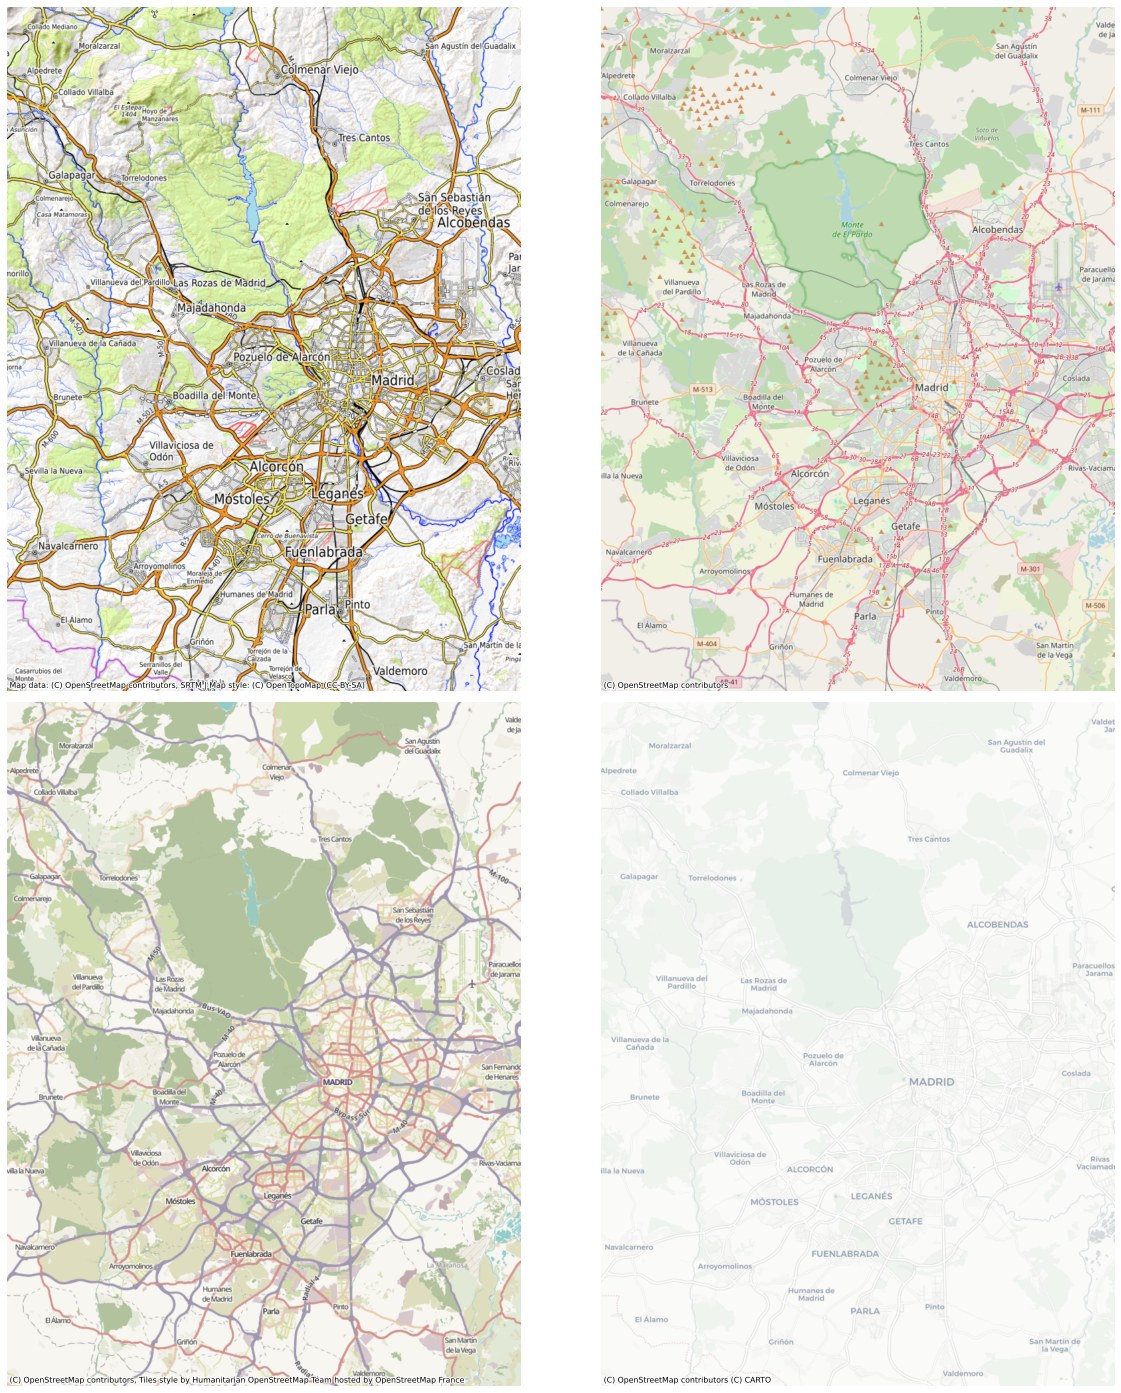

In [5]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
for i, source in enumerate([cx.providers.OpenTopoMap,
               cx.providers.OpenStreetMap.Mapnik,
               cx.providers.OpenStreetMap.HOT,
               cx.providers.CartoDB.Positron
              ]):
    ax = Place("Madrid", source=source).plot(ax=axs.flatten()[i])
    ax.axis("off")
    plt.tight_layout()

There are many providers to choose from. They can be explored from within Python

In [6]:
cx.providers.keys()

dict_keys(['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'Gaode', 'Strava', 'OrdnanceSurvey', 'Stamen'])

The image returned by the `Place` API can be saved separately by specifying the path argument upon instantiation

In [7]:
scq = Place("Santiago de Compostela", path="santiago.tif")

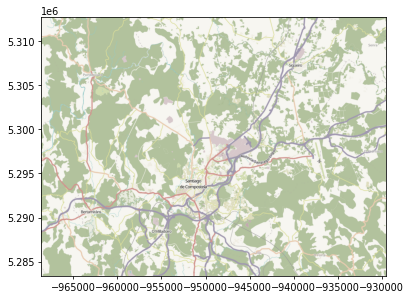

In [8]:
with rasterio.open("santiago.tif") as r:
    rioshow(r)

### Exploring the Place object's attributes

The image can be accessed separately:

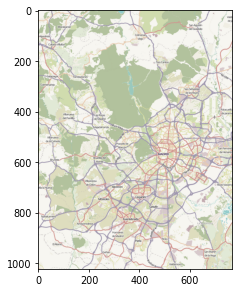

In [9]:
plt.imshow(madrid.im)

If a path has been set at instantiation, the path can also be easily accessed:

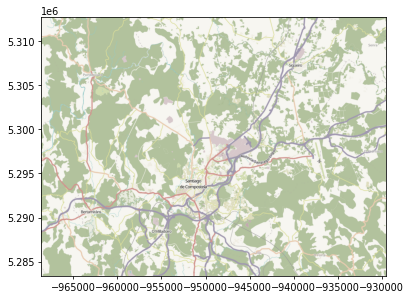

In [10]:
with rasterio.open(scq.path) as r:
    rioshow(r)

The center coordinates of a place as returned by the geocoder are also available

In [11]:
madrid.longitude, madrid.latitude

(-3.7035825, 40.4167047)

The place object has a bounding box of the geocoded place, as well as a bounding box of the map

In [12]:
madrid.bbox

[-3.8889539, 40.3119774, -3.5179163, 40.6437293]

In [13]:
madrid.bbox_map

(-450061.2225431177, -391357.5848201024, 4891969.810251278, 4970241.327215301)

Or you can access the `bbox` elements individually like this:

In [14]:
madrid.w, madrid.s, madrid.e, madrid.n

(-3.8889539, 40.3119774, -3.5179163, 40.6437293)

The bounding box of the map can come in handy when you want to get close-up maps of e.g. certain neighborhoods within a city:

In [15]:
# Create random points within map bbox
Y = np.random.uniform(low=madrid.bbox_map[2], high=madrid.bbox_map[3], size=(8000,))
X = np.random.uniform(low=madrid.bbox_map[1], high=madrid.bbox_map[0], size=(8000,))
r_points = [Point(x,y) for x,y in zip(X,Y)]
df = gpd.GeoDataFrame(r_points, geometry=0, crs="EPSG:3857")

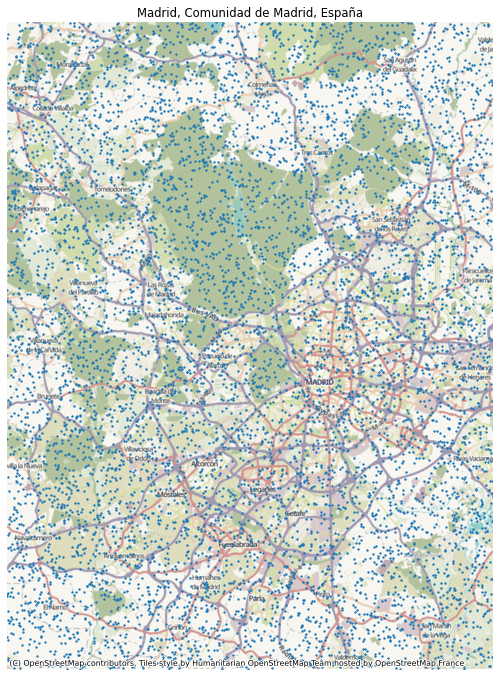

In [16]:
ax = madrid.plot()
ax2 = df.plot(ax=ax, markersize=2)

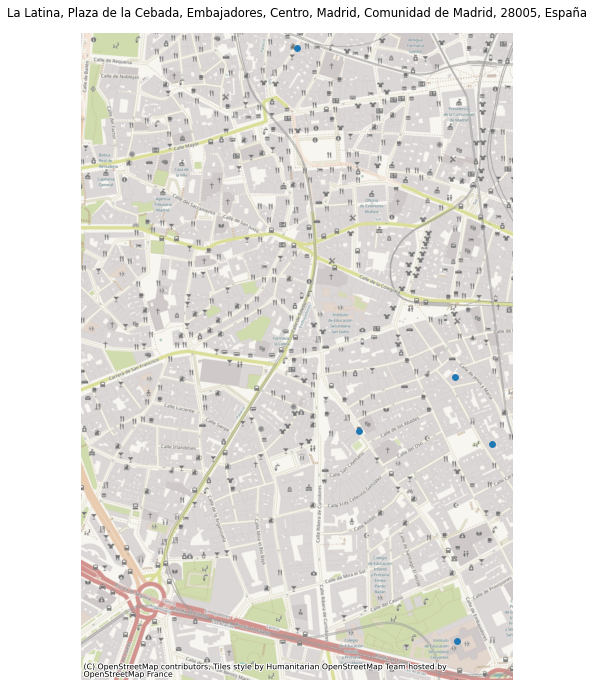

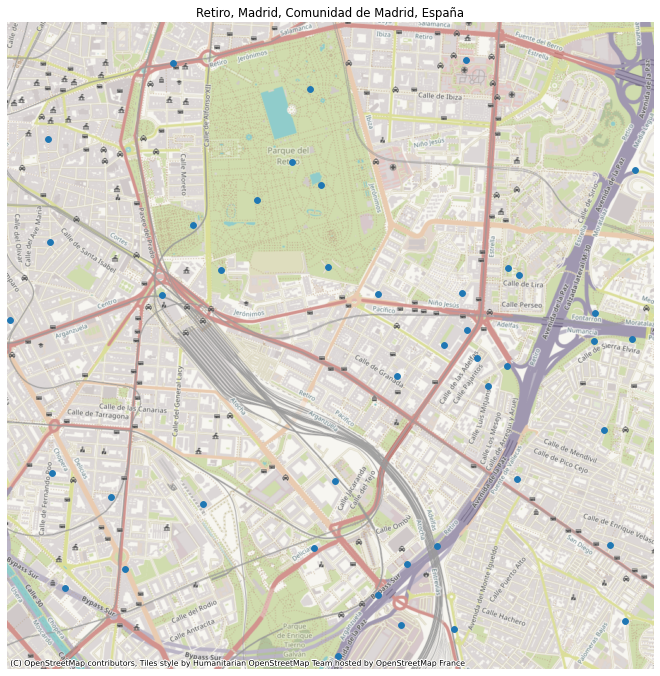

In [17]:
madrid_neighborhoods = ["La Latina", "Retiro"]

for barrio in madrid_neighborhoods:
    place = Place(f"{barrio}, Madrid")
    
    # get close-up maps for each neighborhood
    e, w, s, n = place.bbox_map
    
    ax = place.plot()
    df.cx[e:w, s:n].plot(ax=ax)